In [1]:
import time
t_start1 = time.perf_counter()


%matplotlib inline

## Importing Libraries
import sys
import numbers
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce

import pmdarima as pmd
import statsmodels.api as sm 
from scipy.stats import normaltest

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    Theta
)
from darts.metrics import mape, mase, mae, mse, ope, r2_score, rmse, rmsle
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers.boxcox import BoxCox


from darts.datasets import AirPassengersDataset, AusBeerDataset, GasRateCO2Dataset 
from darts.datasets import HeartRateDataset, IceCreamHeaterDataset, MonthlyMilkDataset
from darts.datasets import SunspotsDataset


import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

2022-05-29 16:47:50 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/s1b0ert/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64

In [2]:
# seasonality default
MSEAS = 12  
# significance level default
ALPHA = 0.05
# training until date AirPassengers
TRAIN = dt.datetime(1957,5,1).date()            

In [3]:

## load data

ts = AirPassengersDataset().load()
#ts = AusBeerDataset().load()
# ts = GasRateCO2Dataset().load()
# ts = HeartRateDataset().load()
# ts = IceCreamHeaterDataset().load()
# ts = MonthlyMilkDataset().load()
# ts = SunspotsDataset().load()


series = ts       #["heater"]
df = ts.pd_dataframe()
df

component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [4]:
df.describe()

component,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [5]:
# replace 0 and NaN by backfilling
s = series.pd_series()
s.replace(0.0, np.nan, inplace=True)
s = s.fillna(method="bfill")
series = series.from_series(s)

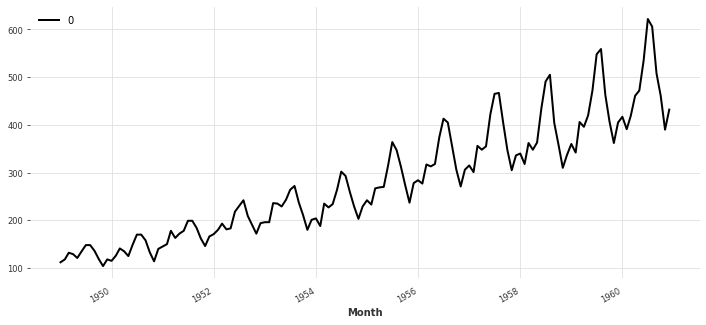

In [6]:
# plot the observations
plt.figure(100, figsize=(12, 5))
series.plot()

In [7]:
# check for seasonality, via ACF

for m in range(2, 25):
    is_seasonal, mseas = check_seasonality(series, m=m, alpha=ALPHA)
    if is_seasonal:
        break

print("seasonal? " + str(is_seasonal))
if is_seasonal:
    print('There is seasonality of order {}.'.format(mseas))

seasonal? True
There is seasonality of order 12.


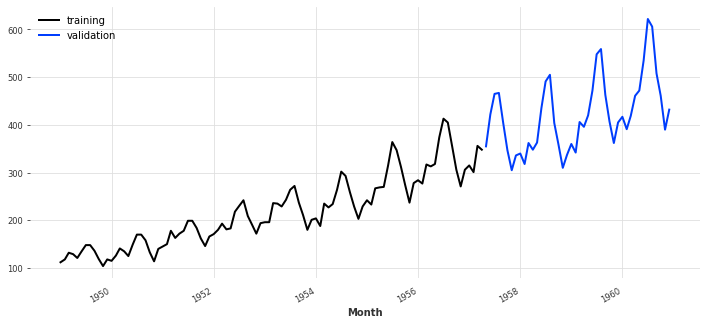

In [8]:
## split train and test data

# split position: if string, then interpret as Timestamp
# if int, then interpretation as index
# if loat, then interpretation as %split
if isinstance(TRAIN, numbers.Number):
    split_at = TRAIN
else:
    split_at = pd.Timestamp(TRAIN)
train, val = series.split_before(split_at)

plt.figure(101, figsize=(12, 5))
train.plot(label='training')
val.plot(label='validation')
plt.legend();

In [9]:
## fit the chosen forecaster model and compute predictions

def eval_model(model):
    t_start =  time.perf_counter()
    print("beginning: " + str(model))


    # fit the model and compute predictions
    res = model.fit(train)
    forecast = model.predict(len(val))

    # for naive forecast, concatenate seasonal fc with drift fc
    if model == m_naive:
        if is_seasonal:
            fc_drift = forecast
            modelS = NaiveSeasonal(K=mseas)
            modelS.fit(train)
            fc_seas = modelS.predict(len(val))
            forecast = fc_drift + fc_seas - train.last_value()


    # compute accuracy metrics and processing time
    res_mape = mape(val, forecast)
    res_mae = mae(val, forecast)
    res_r2 = r2_score(val, forecast)
    res_rmse = rmse(val, forecast)
    res_rmsle = rmsle(val, forecast)
    res_time = time.perf_counter() - t_start
    res_accuracy = {"MAPE":res_mape, "MAE":res_mae, "R squared":-res_r2, "RMSE":res_rmse, "RMSLE":res_rmsle, "time":res_time}

    results = [forecast, res_accuracy]
    print("completed: " + str(model) + ":" + str(res_time) + "sec")
    return results

In [11]:
# laundry list of forecasters to run

m_naive = NaiveDrift()

if is_seasonal:
    m_expon = ExponentialSmoothing(seasonal_periods=mseas)
else:
    m_expon = ExponentialSmoothing()
    
m_prophet = Prophet() 

In [12]:
# prepare ARIMA forecaster

y = np.asarray(series.pd_series())

# get order of first differencing: the higher of KPSS and ADF test results
n_kpss = pmd.arima.ndiffs(y, alpha=ALPHA, test='kpss', max_d=2)
n_adf = pmd.arima.ndiffs(y, alpha=ALPHA, test='adf', max_d=2)
n_diff = max(n_adf, n_kpss)

# get order of seasonal differencing: the higher of OCSB and CH test results
n_ocsb = pmd.arima.OCSBTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
n_ch = pmd.arima.CHTest(m=max(4,mseas)).estimate_seasonal_differencing_term(y)
ns_diff = max(n_ocsb, n_ch, is_seasonal * 1)

# set up the ARIMA forecaster
m_arima = AutoARIMA(
    start_p=1, d=n_diff, start_q=1,
    max_p=4, max_d=n_diff, max_q=4,
    start_P=0, D=ns_diff, start_Q=0, m=max(4,mseas), seasonal=is_seasonal,
    max_P=3, max_D=1, max_Q=3,
    max_order=5,                       # p+q+p+Q <= max_order
    stationary=False, 
    information_criterion="bic", alpha=ALPHA, 
    test="kpss", seasonal_test="ocsb",
    stepwise=True, 
    suppress_warnings=True, error_action="trace", trace=True, with_intercept="auto")

In [13]:
# prepare Theta forecaster

# search space for best theta value: check 100 alternatives
thetas = 2 - np.linspace(-10, 10, 100)

# initialize search
best_mape = float('inf')
best_theta = 0
# search for best theta among 50 values, as measured by MAPE
for theta in thetas:
    model = Theta(theta)
    res = model.fit(train)
    pred_theta = model.predict(len(val))
    res_mape = mape(val, pred_theta)

    if res_mape < best_mape:
        best_mape = res_mape
        best_theta = theta

m_theta = Theta(best_theta)   # best theta model among 100

In [14]:
# laundry list of forecasters to run

models = [ 
    m_expon, 
    m_theta, 
    m_arima,
    m_naive, 
    m_prophet]

# call the forecasters one after the other

model_predictions = [eval_model(model) for model in models]

beginning: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12
completed: ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12:0.15675242200001094sec
beginning: Theta(-3.1515151515151505)
completed: Theta(-3.1515151515151505):0.06295067299998891sec
beginning: Auto-ARIMA
Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=654.738, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=653.262, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=651.601, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=652.131, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=650.926, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=651.998, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=656.051, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : BIC=655.261, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]       

In [15]:
# RUN the forecasters and tabulate their prediction accuracy and processing time

df_acc = pd.DataFrame.from_dict(model_predictions[0][1], orient="index")
df_acc.columns = [str(models[0])]

for i, m in enumerate(models):
    if i > 0: 
        df = pd.DataFrame.from_dict(model_predictions[i][1], orient="index")
        df.columns = [str(m)]
        df_acc = pd.concat([df_acc, df], axis=1)
    i +=1

pd.set_option("display.precision",3)
df_acc.style.highlight_min(color="lightgreen", axis=1).highlight_max(color="yellow", axis=1)

,"ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12",Theta(-3.1515151515151505),Auto-ARIMA,Naive drift model,Prophet
MAPE,5.397259,4.524725,4.725314,7.291782,8.284782
MAE,24.876258,18.912929,19.891990,33.505280,35.085746
R squared,-0.806483,-0.901956,-0.895463,-0.687663,-0.699908
RMSE,33.629260,23.936900,24.716855,42.723752,41.877868
RMSLE,0.069090,0.055713,0.056256,0.090679,0.094986
time,0.156752,0.062951,0.597274,0.055480,3.150102


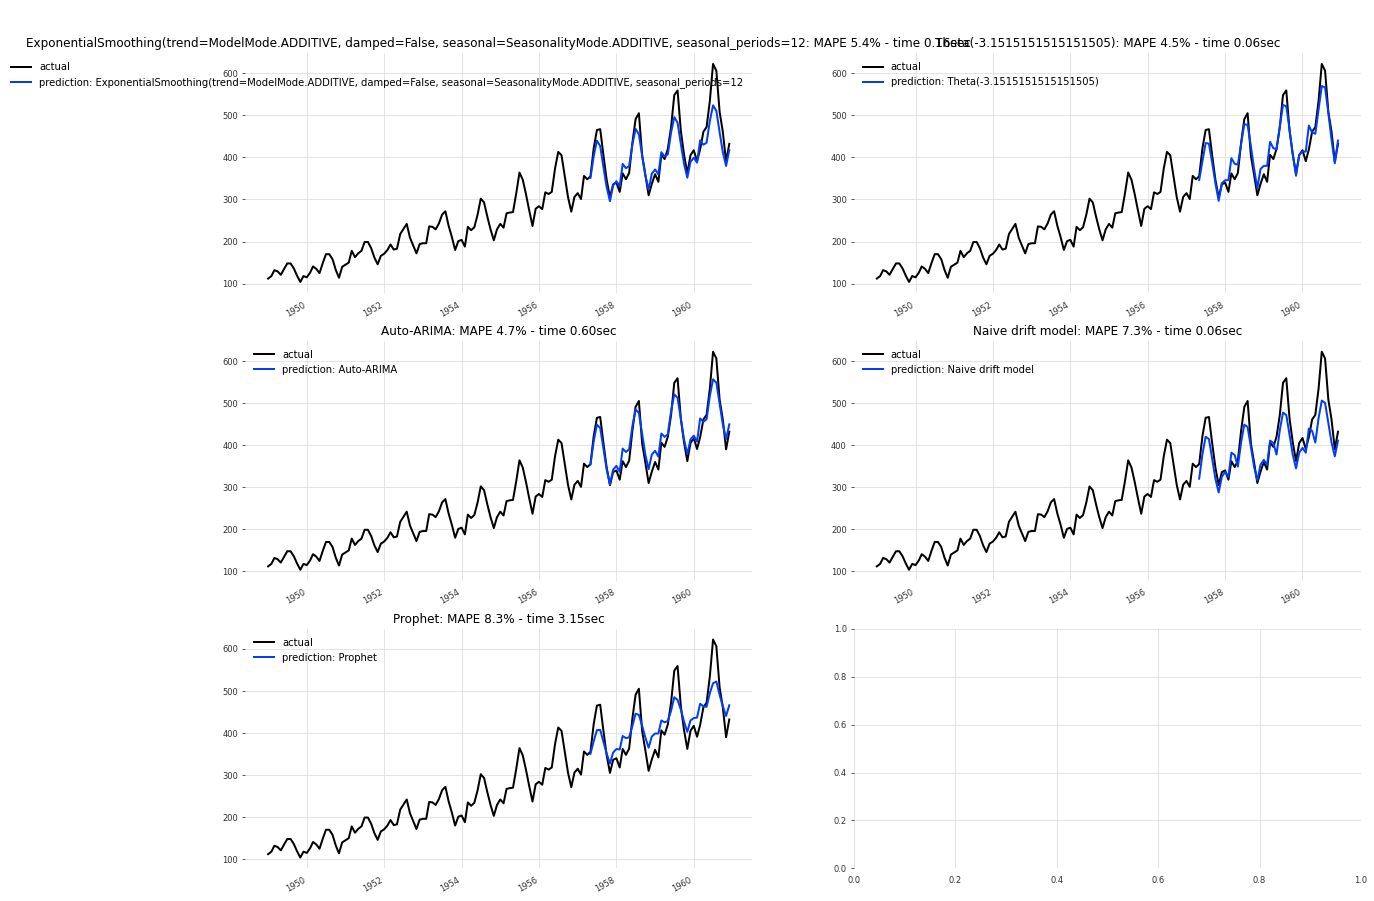

In [16]:
# plot the forecasts

pairs = math.ceil(len(models)/2)                    # how many rows of charts
fig, ax = plt.subplots(pairs, 2, figsize=(20, 5 * pairs))
ax = ax.ravel()

for i,m in enumerate(models):
        series.plot(label="actual", ax=ax[i])
        model_predictions[i][0].plot(label="prediction: "+str(m), ax=ax[i])
        
        mape_model =  model_predictions[i][1]["MAPE"]
        time_model =  model_predictions[i][1]["time"]
        ax[i].set_title("\n\n" + str(m) + ": MAPE {:.1f}%".format(mape_model) + " - time {:.2f}sec".format(time_model))

        ax[i].set_xlabel("")
        ax[i].legend()

In [17]:
# Diagnostics of Residual


act = val

resL = {}
resN = {} 
for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act
        sr = resid.pd_series() 

        resL[str(m)] = sm.stats.acorr_ljungbox(sr, lags=[5], return_df=False)[1][0]
        resN[str(m)] = normaltest(sr)[1]

        
print("\nLjung-Box test for white-noise residuals: p-value > alpha?")
[print(key,":",value) for key,value in resL.items()]

print("\ntest for normality of residuals: p-value > alpha?")
[print(key,":",value) for key,value in resN.items()]


Ljung-Box test for white-noise residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 : 4.1515599870309294e-07
Theta(-3.1515151515151505) : 1.4473990672405963e-05
Auto-ARIMA : 1.628237102007999e-05
Naive drift model : 9.379930722128934e-08
Prophet : 1.0711478747745912e-08

test for normality of residuals: p-value > alpha?
ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=12 : 0.018677772158485286
Theta(-3.1515151515151505) : 0.9052569664215506
Auto-ARIMA : 0.04253256230375704
Naive drift model : 0.17096643152873148
Prophet : 0.10415182634582179


[None, None, None, None, None]

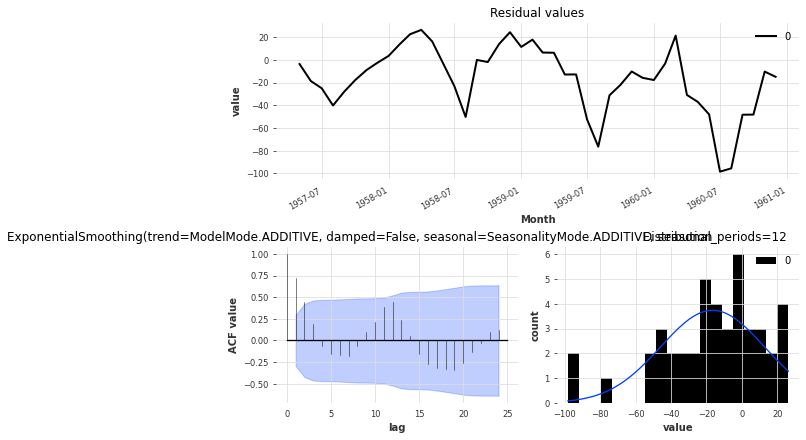

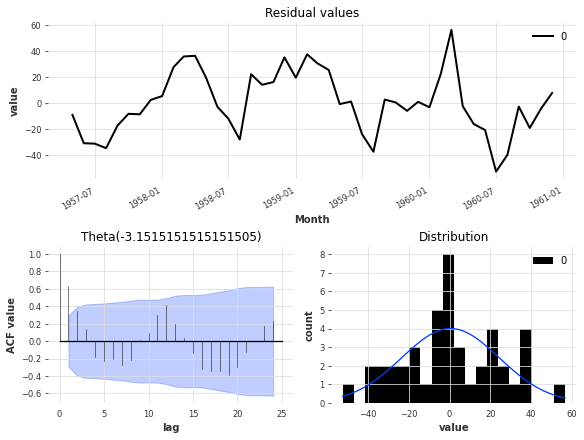

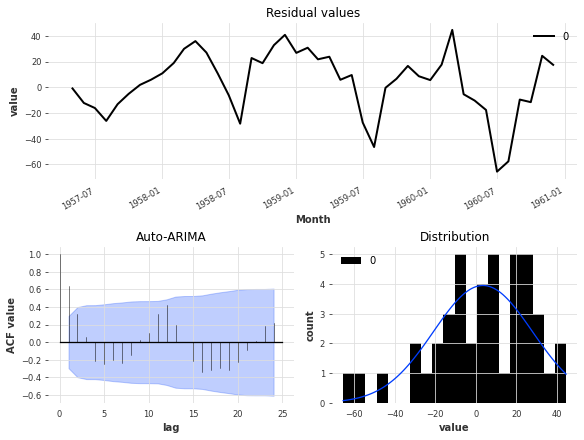

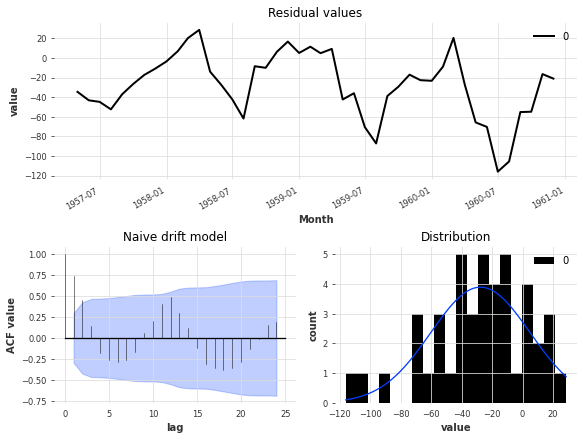

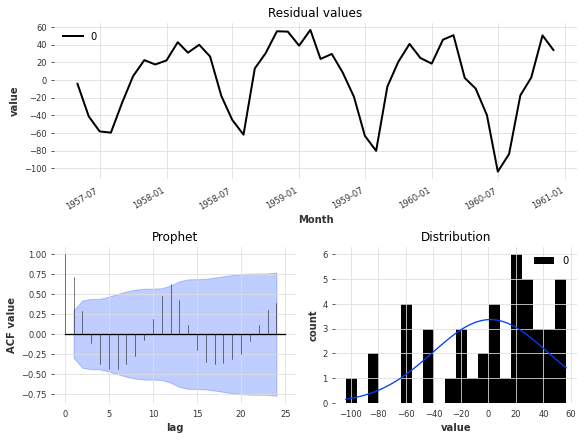

In [32]:
# investigate the residuals in the validation dataset

act = val
df_desc = pd.DataFrame()

for i,m in enumerate(models):
        pred = model_predictions[i][0]
        resid = pred - act

        plot_residuals_analysis(resid);
        plt.title(str(m))

lenght of validation data 44


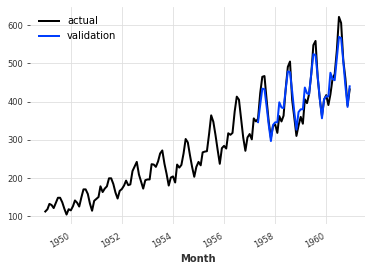

In [43]:
# Exploring Best Model

best_model = m_theta

# fit the model and compute predictions
res = best_model.fit(train)
print(f'lenght of validation data {len(val)}')
forecast = best_model.predict(len(val))

series.plot(label='actual')
forecast.plot(label='validation')

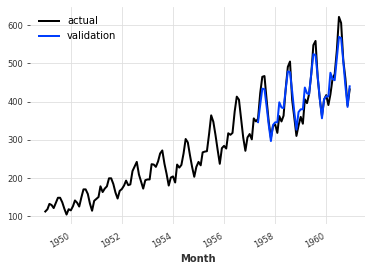

In [42]:
# Backtesting

